In [1]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import re
import string
import nltk
import zipfile

# Define a custom directory for NLTK data on Kaggle
nltk_data_dir = '/kaggle/working/nltk_data'
if not os.path.exists(nltk_data_dir):
    os.makedirs(nltk_data_dir)

# Set the NLTK_DATA environment variable and override nltk.data.path
os.environ['NLTK_DATA'] = nltk_data_dir
nltk.data.path = [nltk_data_dir]

# Force download required NLTK resources into our custom directory
nltk.download('wordnet', download_dir=nltk_data_dir, force=True)
nltk.download('omw-1.4', download_dir=nltk_data_dir, force=True)
nltk.download('stopwords', download_dir=nltk_data_dir, force=True)

# Check if WordNet is extracted; if not, try to extract it manually.
wordnet_path = os.path.join(nltk_data_dir, 'corpora', 'wordnet')
if not os.path.exists(wordnet_path):
    # Look for a zip file in the 'corpora' folder that contains 'wordnet'
    corpora_dir = os.path.join(nltk_data_dir, 'corpora')
    for fname in os.listdir(corpora_dir):
        if 'wordnet' in fname.lower() and fname.endswith('.zip'):
            zip_path = os.path.join(corpora_dir, fname)
            print("Extracting WordNet from:", zip_path)
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall(corpora_dir)
            break

# Verify that WordNet is now available
print("NLTK data paths:", nltk.data.path)
print("WordNet found at:", nltk.data.find('corpora/wordnet'))
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from bayes_opt import BayesianOptimization

import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package wordnet to
[nltk_data]     /kaggle/working/nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /kaggle/working/nltk_data...
[nltk_data] Downloading package stopwords to
[nltk_data]     /kaggle/working/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Extracting WordNet from: /kaggle/working/nltk_data/corpora/wordnet.zip
NLTK data paths: ['/kaggle/working/nltk_data']
WordNet found at: /kaggle/working/nltk_data/corpora/wordnet


In [2]:
# read dataset 
df = pd.read_csv('/kaggle/input/sentiment-analysis/sentiment_analysis.csv')
df.head()

,Year,Month,Day,Time of Tweet,text,sentiment,Platform
0,2018,8,18,morning,What a great day!!! Looks like dream.,positive,Twitter
1,2018,8,18,noon,"I feel sorry, I miss you here in the sea beach",positive,Facebook
2,2017,8,18,night,Don't angry me,negative,Facebook
3,2022,6,8,morning,We attend in the class just for listening teac...,negative,Facebook
4,2022,6,8,noon,"Those who want to go, let them go",negative,Instagram


**Step 1. Explore the dataset**

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Year           499 non-null    int64 
 1   Month          499 non-null    int64 
 2   Day            499 non-null    int64 
 3   Time of Tweet  499 non-null    object
 4   text           499 non-null    object
 5   sentiment      499 non-null    object
 6   Platform       499 non-null    object
dtypes: int64(3), object(4)
memory usage: 27.4+ KB


* Conclusion: data size is 499 records with 7 columns, no missing data, 3 integers and 4 categories.

In [4]:
df.sentiment.value_counts()

sentiment
neutral     199
positive    166
negative    134
Name: count, dtype: int64

In [5]:
df.sentiment.value_counts(normalize=True)

sentiment
neutral     0.398798
positive    0.332665
negative    0.268537
Name: proportion, dtype: float64

<Axes: ylabel='count'>

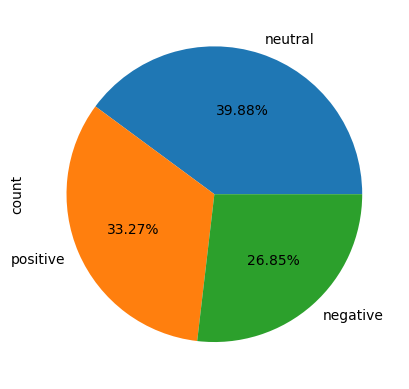

In [6]:
df["sentiment"].value_counts().plot(kind = "pie" , autopct = "%0.2f%%")

* Conclusion: for the target values, we have 199 neutral records, 166 positive records and 134 negative records. Each label has nearly even ratio.

**Step 2. Preprocess the data**

In [7]:
# Initialize stopwords
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def text_preprocessing(text):
    """Clean, lemmatize, and preprocess text."""
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)  # Remove square brackets
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'<.*?>+', '', text)  # Remove HTML tags
    text = re.sub(r'\n', ' ', text)  # Replace new lines with space
    text = re.sub(r'\w*\d\w*', '', text)  # Remove words containing numbers
    text = re.sub(r'[^a-zA-Z!?]', ' ', text)  # Keep special sentiment-related symbols
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text

# Process the DataFrame: ensure "text" is string type and handle any missing values
df["text"] = df["text"].astype(str).fillna("").apply(text_preprocessing)

# Encode sentiment labels
LE = LabelEncoder()
df["Encoded sentiment"] = LE.fit_transform(df["sentiment"])

# Display the first few rows of the processed DataFrame
df.head()

,Year,Month,Day,Time of Tweet,text,sentiment,Platform,Encoded sentiment
0,2018,8,18,morning,great day!!! look like dream,positive,Twitter,2
1,2018,8,18,noon,feel sorry miss sea beach,positive,Facebook,2
2,2017,8,18,night,angry,negative,Facebook,0
3,2022,6,8,morning,attend class listening teacher reading slide n...,negative,Facebook,0
4,2022,6,8,noon,want go let go,negative,Instagram,0


**Step 3.Feature Engineering: TF-IDF with N-grams**

In [8]:
vectorizer = TfidfVectorizer(ngram_range=(1,3), max_features=10000)  # Use unigrams, bigrams, and trigrams
X = vectorizer.fit_transform(df['text'])
y = df['Encoded sentiment']

# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


**Step 4. Model Training and Hyperparameter Tuning**

In [9]:
def optimize_svm(C, gamma):
    """Objective function for Bayesian Optimization of SVM"""
    model = SVC(C=C, gamma=gamma, kernel='rbf')
    model.fit(X_train, y_train)
    return accuracy_score(y_test, model.predict(X_test))

svm_bo = BayesianOptimization(f=optimize_svm, pbounds={"C": (0.1, 10), "gamma": (0.0001, 1)}, random_state=42)
svm_bo.maximize(n_iter=10)

best_svm = SVC(C=svm_bo.max["params"]["C"], gamma=svm_bo.max["params"]["gamma"], kernel="rbf")
best_svm.fit(X_train, y_train)

# === Train Random Forest Model ===
rf_model = RandomForestClassifier(n_estimators=300, max_depth=20, random_state=42)
rf_model.fit(X_train, y_train)

# === Train XGBoost Model ===
xgb_model = XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=6, subsample=0.8, colsample_bytree=0.8)
xgb_model.fit(X_train, y_train)

# === Train LightGBM Model ===
lgbm_model = LGBMClassifier(n_estimators=200, learning_rate=0.1, max_depth=6)
lgbm_model.fit(X_train, y_train)

|   iter    |  target   |     C     |   gamma   |
-------------------------------------------------
| 1         | 0.58      | 3.808     | 0.9507    |
| 2         | 0.6       | 7.347     | 0.5987    |
| 3         | 0.38      | 1.645     | 0.1561    |
| 4         | 0.45      | 0.675     | 0.8662    |
| 5         | 0.59      | 6.051     | 0.7081    |
| 6         | 0.58      | 9.546     | 0.9905    |
| 7         | 0.3       | 8.62      | 0.006107  |
| 8         | 0.59      | 7.016     | 0.6194    |
| 9         | 0.59      | 4.955     | 0.8558    |
| 10        | 0.3       | 4.411     | 0.005008  |
| 11        | 0.58      | 5.547     | 0.9861    |
| 12        | 0.3       | 6.428     | 0.00194   |
| 13        | 0.58      | 6.53      | 0.9988    |
| 14        | 0.62      | 4.012     | 0.4874    |
| 15        | 0.62      | 3.525     | 0.4619    |
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002611 seconds.
You can set `force_row_wise=true` to remove th

LGBMClassifier(max_depth=6, n_estimators=200)

**Step 5. Model Evaluation**


SVM Model Performance:
              precision    recall  f1-score   support

           0       1.00      0.39      0.56        36
           1       0.45      0.97      0.62        30
           2       0.86      0.56      0.68        34

    accuracy                           0.62       100
   macro avg       0.77      0.64      0.62       100
weighted avg       0.79      0.62      0.62       100

SVM Accuracy: 0.62

Random Forest Model Performance:
              precision    recall  f1-score   support

           0       1.00      0.03      0.05        36
           1       0.33      1.00      0.50        30
           2       1.00      0.24      0.38        34

    accuracy                           0.39       100
   macro avg       0.78      0.42      0.31       100
weighted avg       0.80      0.39      0.30       100

Random Forest Accuracy: 0.39

XGBoost Model Performance:
              precision    recall  f1-score   support

           0       0.67      0.33      0.44      

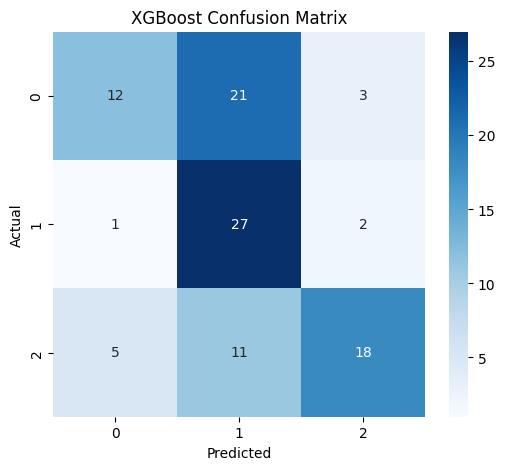

In [10]:
svm_preds = best_svm.predict(X_test)
rf_preds = rf_model.predict(X_test)
xgb_preds = xgb_model.predict(X_test)
lgbm_preds = lgbm_model.predict(X_test)

print("\nSVM Model Performance:")
print(classification_report(y_test, svm_preds))
print("SVM Accuracy:", accuracy_score(y_test, svm_preds))

print("\nRandom Forest Model Performance:")
print(classification_report(y_test, rf_preds))
print("Random Forest Accuracy:", accuracy_score(y_test, rf_preds))

print("\nXGBoost Model Performance:")
print(classification_report(y_test, xgb_preds))
print("XGBoost Accuracy:", accuracy_score(y_test, xgb_preds))

print("\nLightGBM Model Performance:")
print(classification_report(y_test, lgbm_preds))
print("LightGBM Accuracy:", accuracy_score(y_test, lgbm_preds))

# Plot Confusion Matrix for the best model
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, xgb_preds), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("XGBoost Confusion Matrix")
plt.show()

In [11]:
def predict_traditional_model(text, model, vectorizer, label_encoder):
    """
    Predict sentiment using a traditional model (e.g., SVM, Random Forest, etc.).
    
    Parameters:
      text (str): The input sentence to classify.
      model: The trained traditional model (e.g., best_svm).
      vectorizer: The TF-IDF vectorizer used during training.
      label_encoder: The LabelEncoder used to encode sentiment labels.
      
    Returns:
      str: The predicted sentiment label.
    """
    # Preprocess the input text using your defined function
    processed_text = text_preprocessing(text)
    
    # Vectorize the preprocessed text. Note that vectorizer expects an iterable.
    text_vector = vectorizer.transform([processed_text])
    
    # Use the model to predict the sentiment class
    predicted_class = model.predict(text_vector)[0]
    
    # Decode the numeric class back to the original sentiment label
    predicted_label = label_encoder.inverse_transform([predicted_class])[0]
    
    return predicted_label

# Example usage:
test_sentence = "It works wonders and exceeded my expectations."
predicted_sentiment = predict_traditional_model(test_sentence, best_svm, vectorizer, LE)
print("Input:", test_sentence)
print("Predicted Sentiment (Traditional Model):", predicted_sentiment)
    

Input: It works wonders and exceeded my expectations.
Predicted Sentiment (Traditional Model): neutral


# === Alternative Approach: Deep Learning with BERT ===


In [12]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
import numpy as np

# Load the pre-trained BERT tokenizer and model (for 3 sentiment classes)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

# Prepare texts and labels from your DataFrame (df)
texts = df["text"].tolist()  # Ensure this column is preprocessed
labels = df["Encoded sentiment"].values

# Tokenize texts using the BERT tokenizer
def tokenize_texts(texts, tokenizer, max_length=128):
    return tokenizer(
        texts,
        truncation=True,
        padding=True,
        max_length=max_length,
        return_tensors="tf"
    )

tokenized = tokenize_texts(texts, tokenizer, max_length=128)
# Convert the TF tensors to numpy arrays for train_test_split
input_ids = tokenized["input_ids"].numpy()
attention_mask = tokenized["attention_mask"].numpy()

# Split into training and test sets (80-20 split)
train_inputs, test_inputs, train_masks, test_masks, train_labels, test_labels = train_test_split(
    input_ids, attention_mask, labels, test_size=0.2, random_state=42
)

# Create TensorFlow datasets
batch_size = 8
train_dataset = tf.data.Dataset.from_tensor_slices((
    {"input_ids": train_inputs, "attention_mask": train_masks},
    train_labels
)).shuffle(100).batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((
    {"input_ids": test_inputs, "attention_mask": test_masks},
    test_labels
)).batch(batch_size)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Train the model
epochs = 3
history = model.fit(train_dataset, validation_data=test_dataset, epochs=epochs)

# Evaluate the model
results = model.evaluate(test_dataset)
print("Transformer Model Accuracy:", results[1])

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
50/50 [==============================] - 185s 3s/step - loss: 1.0750 - accuracy: 0.4135 - val_loss: 1.1182 - val_accuracy: 0.3300
Epoch 2/3
50/50 [==============================] - 132s 3s/step - loss: 0.8973 - accuracy: 0.6140 - val_loss: 0.7408 - val_accuracy: 0.7000
Epoch 3/3
13/13 [==============================] - 6s 489ms/step - loss: 0.5546 - accuracy: 0.8000
Transformer Model Accuracy: 0.800000011920929


In [13]:
def predict_sentiment(text):
    # Tokenize the input text
    inputs = tokenizer(text, truncation=True, padding=True, max_length=128, return_tensors="tf")
    
    # Get model predictions (logits)
    logits = model(inputs).logits
    
    # Get the predicted class index (using argmax)
    predicted_class = tf.argmax(logits, axis=1).numpy()[0]
    
    # Convert the predicted class index back to the sentiment label using the LabelEncoder
    sentiment_label = LE.inverse_transform([predicted_class])[0]
    
    return sentiment_label

# Example: Test the model with a random sentence
test_sentence = "It works wonders and exceeded my expectations."
predicted_sentiment = predict_sentiment(test_sentence)
print("Input:", test_sentence)
print("Predicted Sentiment:", predicted_sentiment)

Input: It works wonders and exceeded my expectations.
Predicted Sentiment: positive


**Conclusion:**
* within the same example test, Bert works better than TF-IDF + classical ML models.